In [1]:
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Ignore warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

## Data Cleaning

### Loading data and removing missing values

In [2]:
df1 = pd.read_csv('../input/spaceship-titanic/train.csv')
df2 = pd.read_csv('../input/spaceship-titanic/test.csv')

df1 = df1.dropna()
df2 = df2.dropna()

X_train = df1.copy()
X_test = df2.copy()

X_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


### Separating training set

In [3]:
y_train = X_train['Transported']
X_train = X_train.drop(['Transported'], axis=1)

### Removing columns that will not be used for training

In [4]:
X_train = X_train.drop(['Name','PassengerId', 'Cabin'], axis=1)
X_test = X_test.drop(['Name','PassengerId', 'Cabin'], axis=1)

X_train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0


### Turning ordinal features into numeric values

In [5]:
ordinal_feats = ['CryoSleep', 'VIP']
for feat in ordinal_feats:
    encoder = OrdinalEncoder()
    X_train[feat] = encoder.fit_transform(X_train[feat].values.reshape(-1, 1))
    X_test[feat] = encoder.fit_transform(X_test[feat].values.reshape(-1, 1))

y_train = encoder.fit_transform(y_train.values.reshape(-1, 1))

X_train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,Europa,0.0,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Earth,0.0,TRAPPIST-1e,24.0,0.0,109.0,9.0,25.0,549.0,44.0
2,Europa,0.0,TRAPPIST-1e,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0
3,Europa,0.0,TRAPPIST-1e,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0
4,Earth,0.0,TRAPPIST-1e,16.0,0.0,303.0,70.0,151.0,565.0,2.0


### Separating nominal features into separate columns

In [6]:
transformer = make_column_transformer(
    (OneHotEncoder(), ['HomePlanet','Destination']),
    remainder='passthrough')

transformed = transformer.fit_transform(X_train)
X_train = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names())
    
transformed = transformer.fit_transform(X_test)
X_test = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names())

X_train.head()

,onehotencoder__x0_Earth,onehotencoder__x0_Europa,onehotencoder__x0_Mars,onehotencoder__x1_55 Cancri e,onehotencoder__x1_PSO J318.5-22,onehotencoder__x1_TRAPPIST-1e,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,24.0,0.0,109.0,9.0,25.0,549.0,44.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,58.0,1.0,43.0,3576.0,0.0,6715.0,49.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,33.0,0.0,0.0,1283.0,371.0,3329.0,193.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,16.0,0.0,303.0,70.0,151.0,565.0,2.0


### Normilizing data

In [7]:
X_train = normalize(X_train)
X_test = normalize(X_test)

### Performing principle component analysis

In [8]:
pca = PCA(n_components = 0.9, svd_solver='full')
  
X_train = pca.fit_transform(X_train) #Create PCA and apply to train data
X_test = pca.transform(X_test)       #Apply created PCA to new data

### Create validation data from train data

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.8, random_state=1)

## Creating and training classification models

### Function for calculating model performance

In [10]:
def calculate_results(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    
    model_results = {"Accuracy": accuracy,
                     "Precision": precision,
                     "Recall": recall,
                     "F1 Score": f1}
    return model_results

### Random Forest

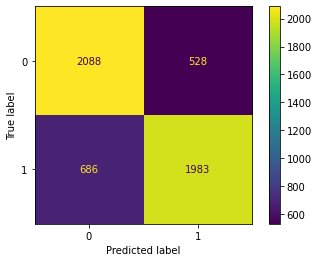

In [11]:
rf = RandomForestClassifier()
model = rf.fit(X_train, y_train)
y_pred = model.predict(X_val)
rf_results = calculate_results(y_val, y_pred)
results = pd.DataFrame(rf_results, index=['Random Forest']).T

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### SVM

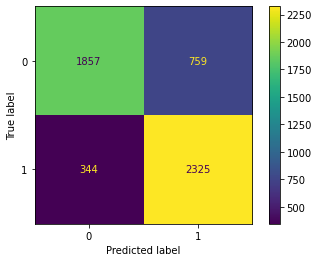

In [12]:
clf = svm.SVC()

clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)
svm_results = calculate_results(y_val, y_pred)
results['SVM'] = pd.DataFrame(svm_results, index=['SVM']).T

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Gradient Boosting

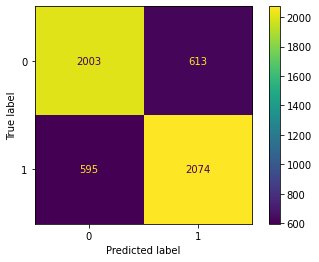

In [13]:
gbr = GradientBoostingClassifier(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                random_state=42) 

model = gbr.fit(X_train, y_train)
y_pred = model.predict(X_val)
gbr_results = calculate_results(y_val, y_pred)
results['Gradient Boosting'] = pd.DataFrame(gbr_results, index=['Gradient Boosting']).T

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### LGBM

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


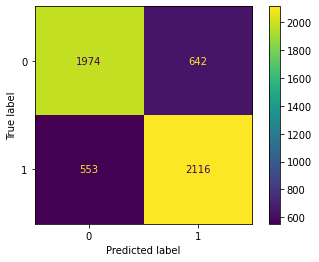

In [14]:
lightgbm = LGBMClassifier(num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

y_pred = lightgbm.fit(X_train, y_train).predict(X_val)
lightgbm_results = calculate_results(y_val, y_pred)
results['LGBM'] = pd.DataFrame(lightgbm_results, index=['LGBM']).T

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [15]:
results

,Random Forest,SVM,Gradient Boosting,LGBM
Accuracy,0.770293,0.791296,0.771429,0.773888
Precision,0.789725,0.753891,0.771865,0.767223
Recall,0.742975,0.871113,0.777070,0.792806
F1 Score,0.765637,0.808274,0.774459,0.779805
